In [1]:
# Common
import os
import numpy as np 
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import clear_output as cls

# Data 
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Pre-Trained Model
from tensorflow.keras.applications import ResNet50V2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

In [3]:

EPOCHS = 50
BATCH_SIZE = 32
SEED = 42
TF_SEED = 768
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
IMAGE_SIZE = (224, 224, 3)

In [4]:
DATASET_PATH = "/kaggle/input/anyas-gojo-revival-aerospace-enigma/train"

train_path = '/kaggle/input/anyas-gojo-revival-aerospace-enigma/train/'
test_path = '/kaggle/input/anyas-gojo-revival-aerospace-enigma/test/'

class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(train_path + name)) for name in class_names]

# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 5 
Class Names : ['commercial', 'glider', 'helicopter', 'mig-29', 'sukhoi']


In [5]:
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [6]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)

    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)

    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.

    # Return image
    return image

def view_sample(image, label, color_map='gray', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    plt.title(f'Label: {label}', fontsize=16)
    return

In [7]:
# Visualize 
fig = px.bar(x=class_names, y=class_dis, title="Training Class Distribution", color=class_names)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [8]:
# !rm /kaggle/working/data -r

In [9]:
!pip install split-folders

In [10]:
import splitfolders
splitfolders.ratio('/kaggle/input/anyas-gojo-revival-aerospace-enigma/train', output="data", seed=1337, ratio=(.80, 0.20)) 

Copying files: 2341 files [00:11, 211.63 files/s]


In [11]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

# Initialize Generator
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

# # Load Data
train_path = "/kaggle/input/anyas-gojo-revival-aerospace-enigma/train"
valid_path = "/kaggle/working/data/val"
train_ds = train_gen.flow_from_directory(train_path, class_mode='binary', target_size=(224,224), shuffle=True, batch_size=32) 
valid_ds = valid_gen.flow_from_directory(valid_path, class_mode='binary', target_size=(224,224), shuffle=True, batch_size=32) 


Found 2341 images belonging to 5 classes.
Found 471 images belonging to 5 classes.


In [12]:
# # Build augmentation layer
# augmentation_layer = Sequential([
#     layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
#     layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
# ], name='augmentation_layer')

In [13]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

In [14]:
def load_image(path):
    '''This function will load the image present at the given location'''
    image = tf.cast(tf.image.resize(img_to_array(load_img(path))/255., (256,256)), tf.float32)
    return image
def show_image(image, title=None):
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



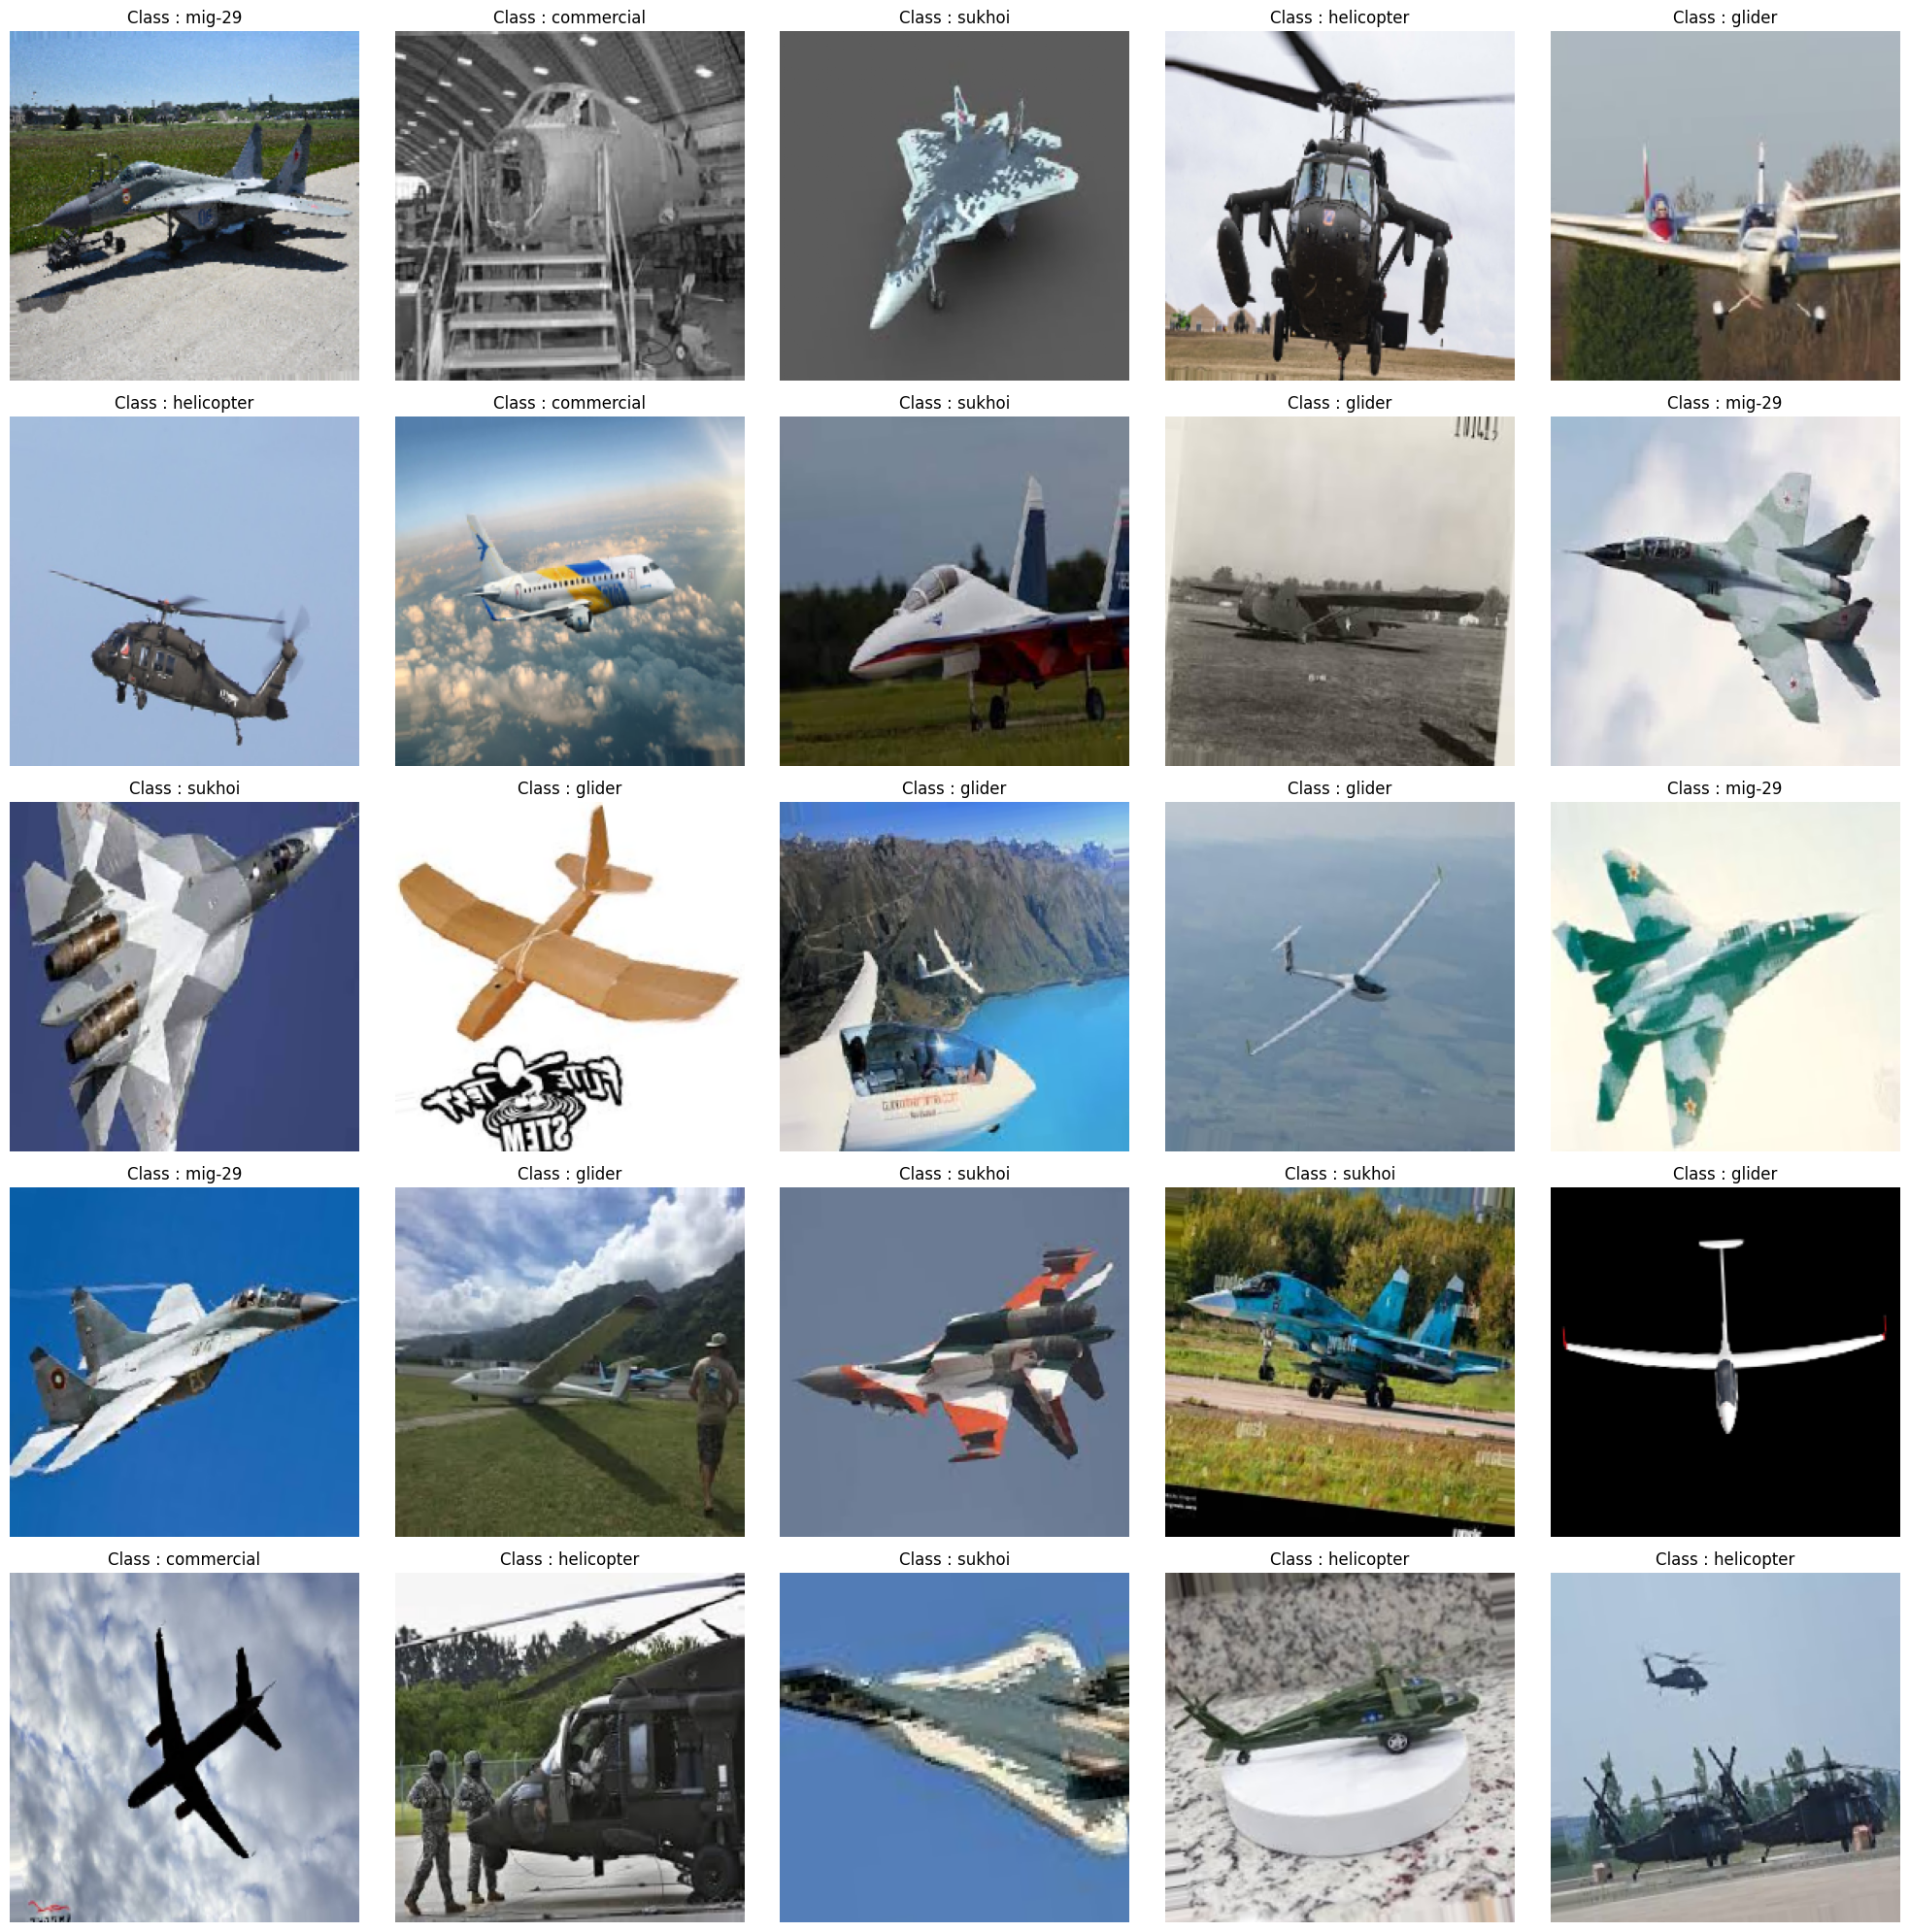

In [15]:
show_images(data=train_ds)

In [16]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [17]:
model = Sequential([
    bit_module,
    Dense(n_classes, activation='softmax', kernel_initializer='zeros')
], name='bit-custom')

In [18]:
BATCH_SIZE = 32
lr = 1e-3 * BATCH_SIZE/512
print(f"Learning rate : {lr}")

Learning rate : 6.25e-05


In [19]:
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
] 

In [20]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        lr,
        lr * 0.1,
        lr * 0.01,
        lr * 0.001,
    ],
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

In [21]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [22]:
cbs = [EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint('bit-custom.h5', save_best_only=True)]

In [23]:

history = model.fit(train_ds, validation_data=valid_ds, epochs=25, callbacks=cbs)


Epoch 1/25
74/74 [==============================] - ETA: 0s - loss: 0.7650 - accuracy: 0.7040

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



74/74 [==============================] - 54s 554ms/step - loss: 0.7650 - accuracy: 0.7040 - val_loss: 0.5480 - val_accuracy: 0.7537
Epoch 2/25
74/74 [==============================] - 40s 534ms/step - loss: 0.4598 - accuracy: 0.8176 - val_loss: 0.4953 - val_accuracy: 0.7665
Epoch 3/25
74/74 [==============================] - 39s 531ms/step - loss: 0.4052 - accuracy: 0.8381 - val_loss: 0.4070 - val_accuracy: 0.8599
Epoch 4/25
74/74 [==============================] - 40s 536ms/step - loss: 0.3736 - accuracy: 0.8659 - val_loss: 0.4033 - val_accuracy: 0.8556
Epoch 5/25
74/74 [==============================] - 39s 531ms/step - loss: 0.3689 - accuracy: 0.8672 - val_loss: 0.4054 - val_accuracy: 0.8556
Epoch 6/25
74/74 [==============================] - 39s 526ms/step - loss: 0.3700 - accuracy: 0.8710 - val_loss: 0.4038 - val_accuracy: 0.8599
Epoch 7/25
74/74 [==============================] - 39s 530ms/step - loss: 0.3671 - accuracy: 0.8701 - val_loss: 0.4036 - val_accuracy: 0.8599
Epoch 8/25

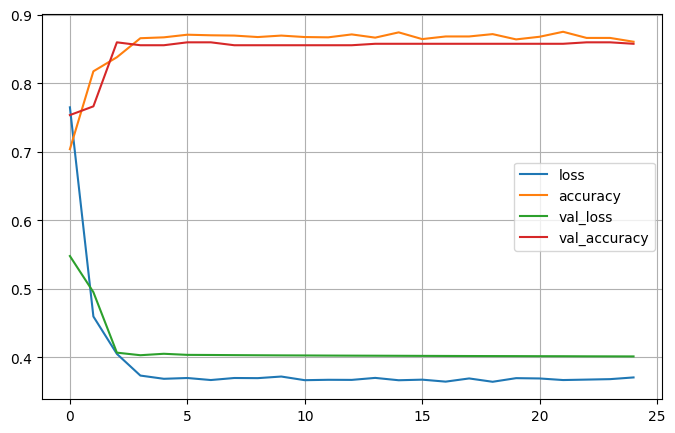

In [24]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid()
plt.show()

In [25]:
path="/kaggle/input/anyas-gojo-revival-aerospace-enigma/test"
ans={}
for file in os.listdir(path):
  val=os.path.splitext(file)[0]
  test_image=tf.keras.utils.load_img(path+'/'+file,target_size=(256,256))
  test_image=tf.keras.utils.img_to_array(test_image)
  test_image=np.expand_dims(test_image,axis=0)
  pred=model.predict(test_image)
  output_class=class_names[np.argmax(pred)]
  ans[file]=output_class

1/1 [==============================] - 0s 27ms/step


In [26]:
import pandas as pd
df= pd.DataFrame([ans.keys(), ans.values()]).T
df.columns= ['image_path', 'Class']

df.set_index('image_path', inplace=True)

df.to_csv('output.csv')